In [1]:
# Replace / with \ if running on windows and make sure to install all dependencies
# To test on other models --- select the model you wish

from __future__ import absolute_import, division, print_function
from tqdm import tqdm    

from termcolor import colored
import tensorflow as tf
import os                   # work with directories
import numpy as np          # dealing with arrays
import matplotlib.pyplot as plt
import time

tfe = tf.contrib.eager
import pickle as pk
import sys

from tensorflow.python.client import device_lib
from tensorflow.python.eager import tape
import  cv2

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
layers = tf.keras.layers
tf.enable_eager_execution(config=config)
tf.executing_eagerly()
print(tf.__version__)

HOME_DIR = os.getcwd()
MAIN_dir = HOME_DIR + '/Cleaned_code/Shared_git/'
checkpoint_path = MAIN_dir + 'checkpoints/'
data_files_path = MAIN_dir + 'data_files/'
mean_path = data_files_path + 'std_mean_60_dataset.npy'
dataset_path = MAIN_dir + 'dataset/'
tensorboard_path = MAIN_dir + 'tensorboard/'

1.12.0


In [2]:

filename = 'sample_set.pickle'
pickle_in_sample = open(MAIN_dir + 'data_files/' + filename, "rb")
sample_data = pk.load(pickle_in_sample)
pickle_in_sample.close()

images = sample_data['images']
labels = sample_data['labels']
speeds = sample_data['speeds']
log_length = sample_data['log_length']


In [ ]:
Batch_size = 8
Buffer_size = 8
Epochs = 100

sample_dataset = tf.data.Dataset.from_tensor_slices((images, labels, speeds, log_length))
sample_dataset = sample_dataset.batch(Batch_size)
sample_dataset = sample_dataset.prefetch(Batch_size)


In [4]:
# LOAD RES-9ER - default  -- choose path
# To test on other models --- select the model you wish
Network_size = None  # Set to default RES-9ER
data_format = 'channels_last'
if Network_size ==16:
    from Shared_git.models import RES_16E as Res9  
    model = Res9.Res16E(data_format=data_format, include_top=True, pooling=None, classes=1)
elif Network_size == 9:
    from Shared_git.models import RES_9E as Res9  
    model = Res9.Res9E(data_format=data_format, include_top=True, pooling=None, classes=1)
else:
    from Shared_git.models import RES_9ER as Res9
    model = Res9.Res9ER(data_format=data_format, include_top=True, pooling=None, classes=1)
    # Instantiate the model and configure tensorbaord and checkpoints

optimizer = tf.train.AdamOptimizer()
accuracy = 0 
acc_prediction = tf.constant(0, dtype="float32")
t = tf.constant(1/7.5, dtype="float32")
loss = tf.constant(0, dtype="float32")
logdir = tensorboard_path
checkpont_path = checkpoint_path+"cp-{log:06d}.ckpt"
checkpont_dir = os.path.dirname(checkpoint_path)
summary_writer = tf.contrib.summary.create_file_writer(logdir)


In [5]:
# LOAD checkpoint if you wish to test results   -- can select other check points based on selected model
checkpoint_name = 'RES_9ER'
model.load_weights(checkpoint_path+checkpoint_name)

In [ ]:
def compute_loss(prediction, label, train_log_length_, operation='L2'):
    if operation == 'L2':
        return tf.divide(tf.squared_difference(prediction, label), train_log_length_)
    elif operation == 'Subtraction':
        return tf.divide(tf.subtract(prediction, label), train_log_length_)
    elif operation == 'L1':
        return tf.divide(tf.abs(tf.subtract(prediction, label)), train_log_length_)
    else:
        raise ValueError('Please specify loss function (L2, L1, Subtraction)')


def print_progress(count, total, cnt, overall, time_, count_log, loss, loss_):
    percent_complete = float(count) / total
    overall_complete = float(cnt) / (overall-1)

    sec = time_ % 60
    mint = int(time_/60) % 60
    hr = int(time_/3600) % 60
    loss = str(loss)
    loss_ = str(loss_)
    msg = "\r Time_lapsed (hr:mm:ss) --> {0:02d}:{1:02d}:{2:02d} ,   loss: {3:s}   Log Progress: {4:.1%},     Overall Progress:{5:.1%}," \
        " completed {6:d} out of 185 logs <--> Initial loss: {7:s} ".format(hr, mint, sec, loss, percent_complete, overall_complete, count_log, loss_)
    sys.stdout.write(msg)
    sys.stdout.flush()
    

def validation_progress(log_cnt, num_logs, time_, loss, accuracy_loc):
    log_cnt += 1
    overall_complete = float(log_cnt) / num_logs
    sec = int(time_) % 60
    mint = int(time_/60) % 60
    hr = int(time_/3600) % 60
    loss = str(loss)
    msg = "\r Validation_Time (hr:mm:ss) --> {0:02d}:{1:02d}:{2:02d} ,   Avg_loss: {3:s}   Avg_accuracy: {4:.1%}   Overall Progress:{5:.1%}," \
        " completed {6:d} out of {7:d} logs".format(hr, mint, sec, loss, accuracy_loc, overall_complete, log_cnt, num_logs)
    sys.stdout.write(colored(msg, 'green'))
    sys.stdout.flush()


def write_summaries(loss, i, global_step, vars_loc, grads_loc, train=True):
    with summary_writer.as_default():
        with tf.contrib.summary.always_record_summaries():
            if train:
                tf.contrib.summary.scalar("train_loss", loss, step=global_step)
                tf.contrib.summary.scalar("step", i, step=global_step)
                #  do not add spaces after names
                tf.contrib.summary.histogram("weights", vars_loc, step=global_step)
                tf.contrib.summary.histogram("gradients", grads_loc, step=global_step)
            else:
                tf.contrib.summary.scalar("val_loss", loss, step=global_step)
                


In [8]:
# VALIDATION CODE

def validate_model(model_loc, val_step_, n_logs, data_set, write_summary=True, return_losses=True):
    logs_N = n_logs
    start = time.time()
    MAE = []
    MSE = []
    MSBE = []
    log_order = []
    Accuracy = []
    metric_mse = []
    summed_volume = 0
    remainder = 0
    iterations = 0
    fixed_size = 0
    count = 0
    new_log = True
    cnt_log = -1
    signal = []
    signals = [] 
    for (batch, (image, label, speed, lengths)) in (enumerate(data_set)):
        size = np.shape(label)[0]
        labels = tf.reshape(label, [size, 1])
        speeds = tf.reshape(speed, [size, 1])
        log_length = tf.squeeze(lengths)
        images = tf.squeeze(image)
        batch += 1
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1

        if count < iterations:
            mass_pred = model_loc(images)
            volume = (mass_pred * speeds) * t
            summed_volume += tf.reduce_sum(volume)
            mass = np.abs(summed_volume.numpy())
            count = count + 1
            signal.append(volume)
            # Compute loss
            if count == iterations and remainder == 0:
                loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
                loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
                loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
                MSE.append(loss_unsigned)
                MAE.append(loss_outlier)
                MSBE.append(loss_signed)
                signals.append(signal[0:len(signal)])
                signal.clear()
        
                gt = np.squeeze(labels[0].numpy())
                metric_mse.append(loss_unsigned)
                
                tmp = np.abs(gt - mass)
                tmp = tmp / gt
                log_acc = 1 - np.squeeze(tmp)
                    
                Accuracy.append(log_acc)
                log_order.append(np.squeeze(log_length[0].numpy()))
                time_ = time.time() - start
                validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))
                if write_summary:
                    write_summaries(np.mean(MSE), 0, val_step_, 0, 0, train=False)
                val_step_ += 1
                # Reset
                summed_volume = 0
                count = 0
                fixed_size = 0
                new_log = True
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            mass_pred = model(images[0:remainder])
            volume = (mass_pred * speeds[0:remainder]) * t
            summed_volume += tf.reduce_sum(volume)
            mass = np.abs(summed_volume.numpy())
            signal.append(volume)
            
            loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
            loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
            loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
            MSE.append(loss_unsigned)
            MAE.append(loss_outlier)
            MSBE.append(loss_signed)
            signals.append(signal[0:len(signal)])
            signal.clear()
            
            gt = np.squeeze(labels[0].numpy())
            metric_mse.append(loss_unsigned)

            tmp = np.abs(gt - mass)
            tmp = tmp / gt
            log_acc = 1 - np.squeeze(tmp)
            
            Accuracy.append(log_acc)
            log_order.append(np.squeeze(log_length[0].numpy()))
            time_ = time.time() - start
            validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))  
            
            if write_summary:  
                write_summaries(np.mean(MSE), 0, val_step_, 0, 0, train=False)
            val_step_ += 1
            summed_volume = 0
            count = 0
            new_log = True
            
            # Handle gradients for the next log
            if cnt_log != logs_N-1:    
                mass_pred = model(images[remainder:])
                volume = (mass_pred * speeds[remainder:]) * t
                summed_volume += tf.reduce_sum(volume)
                signal.append(volume)
                
    if return_losses:
        return MSE, MAE, MSBE, Accuracy, val_step_
    else: 
        return signals

In [8]:
# TRAINING CODE  -- or move the following cell if you just wish to test results and make plots 
save_epoch = 1
init_vol = 0
summed_vol_diff = 0
volume_diff = []
aggregated_diff = []
lamda = 0.05
loss_ = 0
logs_N = 1
start = time.time()
aggregated = []
MSE_log = []
MAE_log = []
MSBE_log = []
MSE_t = []
MAE_t = []
MSBE_t = []
MSE_avg = []
MAE_avg = []
MSBE_avg = []
MSE_train = []
val_step = 1
run_name = 'random'
performance_flag = True
for epoch in range(Epochs):
    loss_metric = 0
    summed_volume = 0
    remainder = 0
    iterations = 0
    fixed_size = 0
    count = 0
    new_log = True
    append_flag = True
    next_log = False
    cnt_log = -1
    first_run = True    
    for (batch, (image, label, speed, lengths)) in (enumerate(sample_dataset)):
        size = np.shape(label)[0]
        labels = tf.reshape(label, [size, 1])
        speeds = tf.reshape(speed, [size, 1])
        log_length = tf.squeeze(lengths)
        images = tf.squeeze(image)
        batch += 1
        step = tf.train.get_or_create_global_step()
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1

        if count < iterations:

            # Compute and Aggregate Gradients
            volume_diff.clear()
            with tf.GradientTape(persistent=True) as tape:
                mass_pred = model(images)   
                # print(np.shape(mass_pred))
                volume = (mass_pred * speeds) * t
                # print(volume)
                for ixd, vol in enumerate(volume):
                    if ixd == 0:
                        summed_vol_diff += tf.squared_difference(volume[ixd], init_vol)
                        volume_diff.append(tf.squared_difference(volume[ixd], init_vol))
                    else:
                        summed_vol_diff += tf.squared_difference(volume[ixd], volume[ixd-1])
                        volume_diff.append(tf.squared_difference(volume[ixd], volume[ixd-1]))
                init_vol = volume[Batch_size-1]
                summed_volume += tf.reduce_sum(volume)
                watched_vars = tape.watched_variables()
            grads = tape.gradient(volume, model.trainable_variables)
            grads_diff = tape.gradient(volume_diff, model.trainable_variables)
            del tape

            if count == 0 and append_flag:
                for idx, grad in enumerate(grads):
                    aggregated.append(grad)
                    aggregated_diff.append(grads_diff[idx])
            else:
                for idx, grad in enumerate(grads):
                    aggregated[idx] = grad+aggregated[idx]
                    aggregated_diff[idx] = grads_diff[idx] + aggregated_diff[idx] 

            count = count + 1

            # Compute loss and Apply Gradients
            if count == iterations and remainder == 0:
                loss = compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction')
                loss_metric = tf.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
                for idx, grd in enumerate(aggregated):
                    aggregated[idx] = (loss * 2 * grd) + (summed_vol_diff * 2 * lamda * aggregated_diff[idx] / log_length[0])
                rmse = tf.sqrt(tf.abs(loss_metric))
                optimizer.apply_gradients(zip(aggregated, model.trainable_variables), global_step=step)
                var_list = model.variables
                write_summaries(loss_metric, batch, step, var_list[0], grads[0], train=True)
                end = time.time() - start
                sec = int(end % 60)
                mint = int(end/60) % 60
                hr = int(end/3600) % 60
                # print(volume[0])
                print("\r Time_lapsed (hr:mm:ss) --> {:02d}:{:02d}:{:02d} Epoch: {}, Log: {}, Log_progress: {:.1%} - Overall_progress: {:.1%}, Length: {} "
                "Label:{}, loss: {:.3f}, train RMSE: {:.2f}".format(hr, mint, sec, epoch+1, cnt_log+1, (cnt_log+1)/logs_N, (epoch+1)/Epochs,  
                log_length[0].numpy(), labels[0].numpy(), loss_metric, rmse))

                if first_run:
                    first_run = False
                    loss_ = loss_metric.numpy()

                # Reset
                aggregated.clear()
                aggregated_diff.clear()
                summed_vol_diff = 0
                init_vol = 0
                summed_volume = 0
                count = 0
                append_flag = True
                fixed_size = 0
                new_log = True

        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            volume_diff.clear()
            with tf.GradientTape(persistent=True) as tape:
                mass_pred = model(images[0:remainder])  
                # print(np.shape(mass_pred))
                volume = (mass_pred * speeds[0:remainder]) * t
                for ixd, vol in enumerate(volume):
                    if ixd == 0:
                        summed_vol_diff += tf.squared_difference(volume[ixd], init_vol)
                        volume_diff.append(tf.squared_difference(volume[ixd], init_vol))
                    else:
                        summed_vol_diff += tf.squared_difference(volume[ixd], volume[ixd-1])
                        volume_diff.append(tf.squared_difference(volume[ixd], volume[ixd-1]))
                init_vol = volume[remainder-1]
                summed_volume += tf.reduce_sum(volume)
                watched_vars = tape.watched_variables()
            grads = tape.gradient(volume, model.trainable_variables)
            grads_diff = tape.gradient(volume_diff, model.trainable_variables)
            del tape

            for idx, grad in enumerate(grads):
                aggregated[idx] = grad+aggregated[idx]
                aggregated_diff[idx] = grads_diff[idx] + aggregated_diff[idx] 

            # Compute loss and apply gradients for the remainder
            loss = compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction')
            loss_metric = tf.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
            for idx, grd in enumerate(aggregated):
                aggregated[idx] = (loss * 2 * grd) + (summed_vol_diff * 2 * lamda * aggregated_diff[idx] / log_length[0])
            rmse = tf.squeeze(tf.sqrt(tf.abs(loss_metric)))
            optimizer.apply_gradients(zip(aggregated, model.trainable_variables), global_step=step)
            var_list = model.trainable_variables
            write_summaries(loss_metric, batch, step, var_list[0], grads[0], train=True)
            end = time.time() - start
            sec = int(end % 60)
            mint = int(end/60) % 60
            hr = int(end/3600) % 60
            # print(volume[0])
            print("\r Time_lapsed (hr:mm:ss) --> {:02d}:{:02d}:{:02d} Epoch: {}, Log: {}, Log_progress: {:.1%} - Overall_progress: {:.1%}, Length: {} "
                  "Label:{}, loss: {:.3f}, train RMSE: {:.2f}".format(hr, mint, sec, epoch+1, cnt_log+1, (cnt_log+1)/logs_N, (epoch+1)/Epochs,  
                  log_length[0].numpy(), labels[0].numpy(), loss_metric, rmse))

            if first_run:
                first_run = False
                loss_ = loss_metric.numpy()

            # Reset
            aggregated.clear()
            aggregated_diff.clear()
            summed_vol_diff = 0
            init_vol = 0
            summed_volume = 0
            count = 0
            append_flag = True
            new_log = True

            # Handle gradients for the next log
            if cnt_log != logs_N-1:
                # Compute and Aggregate Gradients
                volume_diff.clear()
                with tf.GradientTape(persistent=True) as tape:
                    mass_pred = model(images[remainder:])
                    # print(np.shape(mass_pred))
                    volume = (mass_pred * speeds[remainder:]) * t
                    for ixd, vol in enumerate(volume):
                        if ixd == 0:
                            summed_vol_diff += tf.squared_difference(volume[ixd], init_vol)
                            volume_diff.append(tf.squared_difference(volume[ixd], init_vol))
                        else:
                            summed_vol_diff += tf.squared_difference(volume[ixd], volume[ixd-1])
                            volume_diff.append(tf.squared_difference(volume[ixd], volume[ixd-1]))
                    init_vol = volume[Batch_size-remainder-1]

                    summed_volume += tf.reduce_sum(volume)
                    watched_vars = tape.watched_variables()
                grads = tape.gradient(volume, model.trainable_variables)
                grads_diff = tape.gradient(volume_diff, model.trainable_variables)
                del tape

                for idx, grad in enumerate(grads):
                    aggregated.append(grad)
                    aggregated_diff.append(grads_diff[idx])
                append_flag = False
    # Validate model every epoch to determine early stopping
    MSE_log, MAE_log, MSBE_log, accuracy_, val_step = validate_model(model, val_step, 1, sample_dataset, write_summary=True,
                                                                     return_losses=True)
    print('\n')
    MSE_t.append(MSE_log)   # contains log losses for each epoch
    MAE_t.append(MAE_log)
    MSBE_t.append(MSBE_log)
    MSE_avg.append(np.mean(MSE_log))    # contains average log losses for each epoch
    MAE_avg.append(np.mean(MAE_log))
    MSBE_avg.append(np.mean(MSBE_log))
    MSE_train.append(loss_metric)
    error = 1 - np.mean(accuracy_)
    full_data_dict= {"MSE_t": MSE_t, "MAE_t": MAE_t, "MSBE_t": MSBE_t, "MSE_avg": MSE_avg, "MAE_avg": MAE_avg, "MSBE_avg": MSBE_avg, "MSE_train": MSE_train}
    pickle_out = open(MAIN_dir+"data_files/"+"losses_"+run_name+".pickle", "wb")
    pk.dump(full_data_dict, pickle_out)
    pickle_out.close()

    # save model weights every epoch after 50 epochs lapsed
    if performance_flag:
        if error <= 0.06:
            model.save_weights(checkpont_path.format(log=epoch))  
    else:
        if epoch >= save_epoch:
            model.save_weights(checkpont_path.format(log=epoch))

    if error <= 0.02:
        epoch = 1000   # end training
        break

model.save_weights(checkpoint_path + 'cp-'+run_name+'.ckpt')

In [9]:

signals = validate_model(model, 1, 1, sample_dataset, write_summary=False, return_losses=False)


 Validation_Time (hr:mm:ss) --> 00:00:00 ,   Avg_loss: 0.3408467   Avg_accuracy: 97.9%   Overall Progress:100.0%, completed 1 out of 1 logs

In [17]:
signal = []
signalz = []
onehot_signals = []
speed_signal = []
cnt = 0
target_name = 'sample_signal.npy'
for sig in tqdm(signals):
    for si in sig:
        for s in si:
            sm = np.float32(np.squeeze(s.numpy()))
            signal.append(sm)
            speed_signal.append(speeds[cnt])
            onehot_signals.append(sm)
            cnt += 1
    signalz.append([labels[cnt-1], log_length[cnt-1], signal[:len(signal)], 
                    speed_signal[:len(speed_signal)]])
    signal.clear()
    speed_signal.clear()


np.save(data_files_path+target_name, signalz)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 15.05it/s]

Ground Truth:290.29888 Prediction:296.2851371645508 


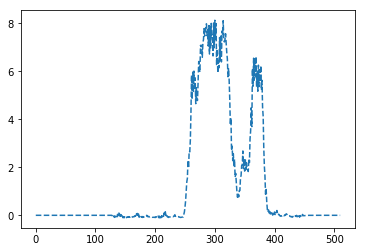

In [26]:
signal = signalz[0][2]
lb2kg = 0.453592
gt = np.squeeze(signalz[0][0]) * lb2kg
prd = np.sum(signalz[0][2]) * lb2kg
plt.plot(signalz[0][2], '--')
print('Ground Truth:{0:} Prediction:{1:} '.format(gt, prd))